\begin{titlepage}
   \vspace*{\stretch{1.0}}
   \begin{center}
      \Large\textbf{Final Project}\\
      \Large\text{Report}\\
      \large\textit{Taha Bouhoun}
   \end{center}
   \vspace*{\stretch{2.0}}
\end{titlepage}

## Problem Description: 
Detail your chosen optimization problem here, giving the context and justification for optimizing [#rightproblem]

The fundamental problem of causal inference is that we do not observe both potential outcomes of a single unit across the same timeline. In other words, if we want to disentangle the causal effect of a treatment for a given unit, we need to compare the outcome of the unit in the presence and absense of the treatment (e.g., in a medical trial, a patient cannot be in both the treatment and control group at the same time, thus, we can't observe their outcome in both worlds).

However, we can approximate the counterfactual (the outcome of the treated unit had it not been subjected to treatment) using Synthetic Control Method designed by Abadie, Diamond, and Hainmueller (2010). The plan is to construct a synthetic version of the treated unit based on a convex combination of control group units such the the error between the treated unit and the synthetic unit is minimized during the pre-treatment period.

The aim of this final project is to
- Replicate the findings of the original paper of Synthetic Control Method: Using CVXPY, I will formulate the SCM method as a convex minimization problem and compare it with the findings of the original paper.
- Provide a basis for Synthetic Control Method in Python: To date, the implimentation of SCM in only availible in R, MATLAB, and Stata. Thus, the formulation of SCM in Python using CVXPY package can be a start for a Python implimentation of the method.

## Methodology:
The original paper's aim was to disentangle the causal effect of German reunification in 1990 (treatment year) on West Germany's Gross Domestic Product. First, we gather data of the OECD countries from 1960 to 2003, then we split the data into two sections (pre-treatment & post-treatment). We then construct a covariate matrix of the treated unit (West Germany) $X_{1}$ and for the control units $X_{0}$ (rest of OECD). The benchmark is to have the best fit for West Germany' GDP trend and its constrcuted synthetic version during the pre-treatment period to have a credible comparaison in the post-treatment period.
First, I addredd a simplified version of the problem on which the covariates have the same importance (weights), then I propose an approach to taking specifying weights for the covariates. 


*Note: The outcome variable (GDP) is excluded from the covariate matrices*

### Simplified problem formulation:

Objective: $$\min\sum_{k=1}^k\left(X_1-W^{\ast}X_0\right)^2$$

Subject to: $$\sum_{j=1}^jW^{\ast}=1$$

Such as:
- $j$ is the number of control units
- $k$ is the number of covariates
- $X_{1}$ is a $(1\times k)$ vector of observed covariates of the treated unit
- $X_{0}$ is a $(j\times k)$ matrix of observed covariates of the control group
- $W^\ast$ is a $(1\times j)$ vector of weights

The aim is to minimize the error distance between the outcome of the treated unit $Y_{1}$ and the product of the optimal weights $w^\ast$ by the outcome of the control units in the pre-treatment period $T_{0}$ such that:

$$W^{\ast}\times Y_0\approx Y_1$$

Where:
- $Y_{1}$ is a $(1\times T_{0})$ vector of the outcome variable of the treated unit in the pre-treatment period
- $Y_{0}$ is a $(j\times T_{0})$ matrix of the outcome variable of the control units in the pre-treatment period


Once we establish a good fit for the synthetic version and the treated unit, we can extrapolate the comparaison to the post-treatment period $T_{1}$ such that the treatment effect $\hat{\alpha}$ is expressed as:
$$\hat{\alpha}=Y_{1T_{1}}-\sum_{k=1}^kW^{\ast}Y_{0T_{1}}$$


### Incorporating the covariates' importance matrix:
As mentioned in the methodology, the simplified version attributes the same importance to covariates which can be problematic given their different units and how they contribute differently to the error we're trying to minimize. To illustrate the idea, imagine if we take as covariate 
- *trade* in units of millions of dollars
- *unemployment rate* in percentage out of 100\%
Both covariates contribute differently to the error rate, an error of 10$ in trade is not equivalent to a 10\% gap in unemployment rate.
By introducing a diagonal matrix V, each coravariate is attributed a weight that reflects its importance in terms of predicting the fit with the treated unit trend. The problem then is formulated as follow:

We pick a diagonal matrix V to find the optimal weights W:
$$\min\left(X_1-X_0W\right)^TV\left(X_1-X_0W\right)$$

We use the matrix V to test how well the it fits the outcome of the treated unit:
$$V^{\ast}=\min\left[\left(Y_1-Y_0W^{\ast}\left(V\right)\right)^T\left(Y_1-Y_0W^{\ast}\left(V\right)\right)\right]$$

The process of finding V can be seen as an optimization problem on its own as the values of W differ as we change our choice of the importance metrix V. As a result, the problem is rendred non-convex as the following objective function can't contain both W and V as unknown variable subject to optimization:

Objective: $$\min\left[V\left(X_1-X_0W\right)^2\right]$$

A strategy to conserve the DCP rules is to fix one variable to optimize for the other then vice versa, however, the attempt was fruitless as the process didn't converge to a reasonable distribution of weights (all weights were attributed to a single unit).

In [ ]:
#!pip install scipy -U

In [1]:
import scipy.optimize

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import cvxpy as cvx
import numpy as np

## Processing data

In [3]:
data = pd.read_csv('german_reunification.csv')

tr_unit = data[data.country == 'West Germany']
tr_unit = tr_unit[tr_unit.year < 1990]
y_tr = np.array(tr_unit.gdp).reshape(1, 30)

ctr_units = data[data.country != 'West Germany']
ctr_units = ctr_units[ctr_units.year < 1990]
y_ctr = np.array(ctr_units.gdp).reshape(16, 30)

tr_unit_all = data[data.country == 'West Germany']
y_tr_all = np.array(tr_unit_all.gdp).reshape(1, 44)

ctr_units_all = data[data.country != 'West Germany']
y_ctr_all = np.array(ctr_units_all.gdp).reshape(16, 44)

In [4]:
X1 = data[data.country =='West Germany']
X1 = X1[X1.year < 1990]
X1 = X1.drop(['code','country','gdp', 'year'], axis=1)
X1 = X1.set_index(np.arange(len(X1)) // 30).mean(level=0)
X1 = X1.values

X0 = data[data.country != 'West Germany']
X0 = X0[X0.year < 1990]
X0 = X0.drop(['code','country','gdp', 'year'], axis=1)
X0 = X0.set_index(np.arange(len(X0)) // 30).mean(level=0)
X0 = X0.values
X0.shape, X1.shape

((16, 7), (1, 7))

## Part I

In [5]:
# Construct the problem
w = cvx.Variable((1, 16), nonneg=True)

objective = cvx.Minimize(cvx.sum_squares(X1 - w @ X0))

constraints = [cvx.sum(w) == 1]

prob = cvx.Problem(objective, constraints)

# The optimal objective value is returned by prob.solve()
result = prob.solve(verbose=True)

print('The optimal objective value: ',result,'\n\nWeights: ',w.value)

-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 23, constraints m = 24
          nnz(P) + nnz(A) = 158
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   5.58e+01   1.71e+04   1.00e-01   1.94e-04s
 200   2.5574e+01   1.11e-02   8.12e-02   3.01e+00   7.71e-04s
 400   3.9777e+01   1.21e-03   9.31e-03   3.01e

In [6]:
result = pd.DataFrame({'Country':data[data.country!='West Germany'].country.unique(), 
                       'Weight': np.round(w.value[0], decimals=3)})
result

,Country,Weight
0,USA,0.307
1,UK,0.000
2,Austria,0.661
3,Belgium,0.000
4,Denmark,0.000
5,France,0.000
6,Italy,0.000
7,Netherlands,0.000
8,Norway,0.000
9,Switzerland,0.000


In [7]:
# Comparing between the error of the optimizer fit and the Abadie et. al fit
w_opt = np.array([0.22, 0, 0.42, 0, 0, 0, 0, 0.09, 0, 0.11,
                  0.16, 0, 0, 0, 0, 0]).reshape(1, 16)

data_compare = pd.DataFrame({'Optimizer':(w @ X0).value[0], 
                             'Opt vs Tr': (w @ X0).value[0] - X1[0],
                             'Paper':(w_opt @ X0)[0], 
                             'Paper vs Tr': (w_opt @ X0)[0] - X1[0],
                             'Treated Unit':X1[0]}, index= data.columns[4:])
data_compare

,Optimizer,Opt vs Tr,Paper,Paper vs Tr,Treated Unit
infrate,4.775253,1.386404,4.793337,1.404488,3.388849
trade,46.588107,0.831420,48.260972,2.504285,45.756687
schooling,50.812894,-4.970439,45.611666,-10.171667,55.783333
invest60,0.257546,-0.079834,0.277653,-0.059727,0.337380
invest70,0.291181,-0.034458,0.316638,-0.009002,0.325640
invest80,25.428058,-1.589940,27.081760,0.063762,27.017998
industry,36.223929,-3.465587,36.472458,-3.217059,39.689516


In [8]:
sum((w.value @ X0 - X1)[0]), sum((w_opt @ X0 - X1)[0])

(-7.922435428769463, -9.484920562009224)

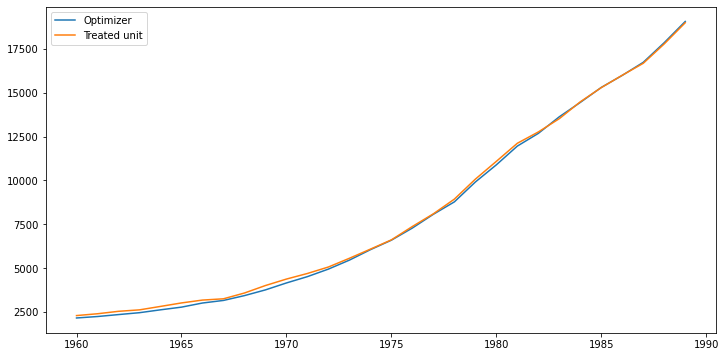

In [9]:
plt.figure(figsize=(12, 6))
plt.plot(list(range(1960, 1990)), w.value[0] @ y_ctr, label='Optimizer')
#plt.plot(np.array(range(1960, 1990)), (w_opt @ y_ctr)[0], label='Paper')
plt.plot(list(range(1960, 1990)), y_tr[0], label='Treated unit')
plt.legend()
plt.show()

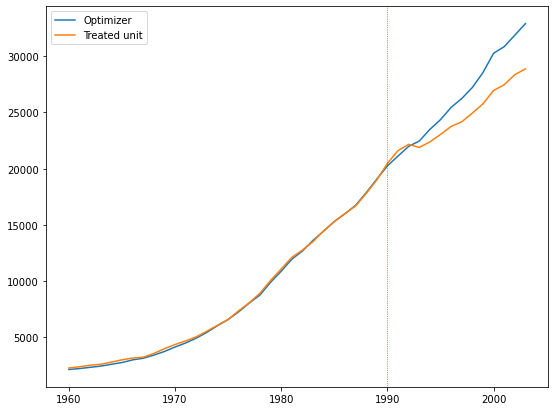

In [10]:
plt.figure(figsize=(9, 7))
plt.plot(list(data.year.unique()), w.value[0] @ y_ctr_all, label='Optimizer')
#plt.plot(list(data.year.unique()), (w_opt @ y_ctr_all)[0], label='Paper')
plt.plot(list(data.year.unique()), y_tr_all[0], label='Treated unit')
plt.axvline(1990, color='red', linewidth=.7, linestyle=':')
plt.legend()
plt.show()

## Part II

In [11]:
# All covariates

X0_T = (X0.T)
X0_T = np.array(X0_T).reshape(7, 16)
X1_T = (X1.T)
X1_T = np.array(X1_T).reshape(7, 1)

y_ctr_T = y_ctr.reshape(30, 16)
y_tr_T = y_tr.reshape(30, 1)

In [12]:
def total_loss(V_diag, details=False):
    ''' 
    Finds W that minimizes total loss given V,
    Returns total loss
    '''
    V = np.zeros(shape=(7, 7))
    np.fill_diagonal(V, V_diag)
    # Construct the problem
    w = cvx.Variable((16, 1), nonneg=True)
    objective = cvx.Minimize(cvx.sum(V @ cvx.square(X1_T - X0_T @ w)))
    constraints = [cvx.sum(w) == 1]
    problem = cvx.Problem(objective, constraints)
    result = problem.solve(verbose=details)

    return float((y_tr_T - y_ctr_T @ w.value).T @ (y_tr_T - y_ctr_T @ w.value)), w

### Generating random V

In [13]:
# Helpless attempt to avoid the DCP rules
record = []
for i in range(1000):
    if (i+1)%100 == 0: print('{}%'.format((i+1)/10))
    new_V = np.random.dirichlet(np.ones(7), size=1)
    record.append([total_loss(new_V)[0], new_V])

10.0%
20.0%
30.0%
40.0%
50.0%
60.0%
70.0%
80.0%
90.0%
100.0%


In [81]:
results = pd.DataFrame(record, columns=['Error', 'Importance'])\
            .sort_values(by='Error', ascending=True)
results = results.reset_index()
results.head(10)

,index,Error,Importance
0,801,9.942145e+08,"[[0.0005087338248272876, 0.1500022324198057, 0..."
1,242,9.942828e+08,"[[0.03737206256530346, 0.2874155630356025, 0.3..."
2,871,9.962772e+08,"[[0.02503715369817736, 0.40454433179072724, 0...."
3,685,9.964648e+08,"[[0.17318516352589805, 0.19364976271483597, 0...."
4,950,9.969772e+08,"[[0.04774285487534092, 0.20207675081546259, 0...."
5,144,9.972595e+08,"[[0.036155841489130564, 0.06906128735274225, 0..."
6,430,9.991098e+08,"[[0.04555884737334239, 0.19507913975791022, 0...."
7,14,1.000229e+09,"[[0.051144883654545385, 0.13424315261686, 0.48..."
8,679,1.000793e+09,"[[0.11099965375990348, 0.08697207154132884, 0...."
9,358,1.001793e+09,"[[0.08570762477636173, 0.07274630890877992, 0...."


In [83]:
W = total_loss(results.iloc[0][1], details=True)[1].value

pd.DataFrame({'Country':data[data.country!='West Germany'].country.unique(), 
              'Weight': np.round(W.T[0], decimals=3)})

-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 23, constraints m = 24
          nnz(P) + nnz(A) = 158
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   5.58e+01   2.16e+08   1.00e-01   1.33e-04s
 200   6.6906e+06   8.53e-02   1.02e+04   2.28e+01   4.41e-04s
 400   2.0543e+08   7.01e-02   1.79e+05   2.73e

,Country,Weight
0,USA,0.305
1,UK,0.000
2,Austria,0.662
3,Belgium,0.000
4,Denmark,0.000
5,France,0.000
6,Italy,0.000
7,Netherlands,0.000
8,Norway,0.000
9,Switzerland,0.000


In [84]:
pd.DataFrame({'Covariate': data.columns[4:], 
              'Weight': np.round(results['Importance'][0][0], 3)})

,Covariate,Weight
0,infrate,0.001
1,trade,0.150
2,schooling,0.077
3,invest60,0.559
4,invest70,0.172
5,invest80,0.022
6,industry,0.020


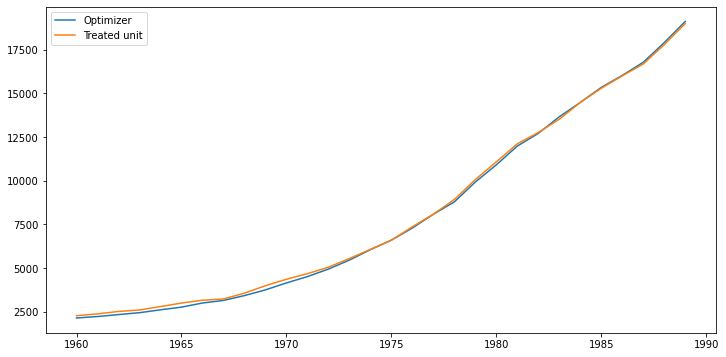

In [85]:
plt.figure(figsize=(12, 6))
plt.plot(list(range(1960, 1990)), (W.T @ y_ctr)[0], label='Optimizer')
#plt.plot(np.array(range(1960, 1990)), (w_opt @ y_ctr)[0], label='Paper')
plt.plot(list(range(1960, 1990)), y_tr[0], label='Treated unit')
plt.legend()
plt.show()

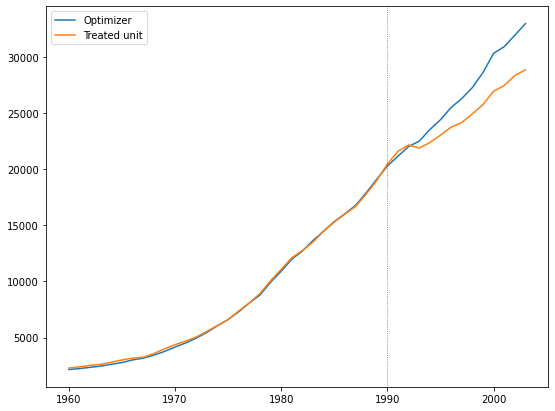

In [86]:
plt.figure(figsize=(9, 7))
plt.plot(list(data.year.unique()), (W.T @ y_ctr_all)[0], label='Optimizer')
#plt.plot(list(data.year.unique()), (w_opt @ y_ctr_all)[0], label='Paper')
plt.plot(list(data.year.unique()), y_tr_all[0], label='Treated unit')
plt.axvline(1990, color='red', linewidth=.7, linestyle=':')
plt.legend()
plt.show()

In [87]:
# Comparing between the error of the optimizer fit and the Abadie et. al fit
data_compare = pd.DataFrame({'Optimizer':(W.T @ X0)[0], 
                             'Opt vs Tr': (W.T @ X0 - X1)[0],
                             'Paper':(w_opt @ X0)[0], 
                             'Paper vs Tr': (w_opt @ X0 - X1)[0],
                             'Treated Unit':X1[0]}, index= data.columns[4:])
data_compare

,Optimizer,Opt vs Tr,Paper,Paper vs Tr,Treated Unit
infrate,4.799544,1.410694,4.793337,1.404488,3.388849
trade,46.725660,0.968973,48.260972,2.504285,45.756687
schooling,50.961441,-4.821892,45.611666,-10.171667,55.783333
invest60,0.258649,-0.078731,0.277653,-0.059727,0.337380
invest70,0.292291,-0.033349,0.316638,-0.009002,0.325640
invest80,25.531910,-1.486088,27.081760,0.063762,27.017998
industry,36.336928,-3.352588,36.472458,-3.217059,39.689516


In [88]:
sum((W.T @ X0 - X1)[0]), sum((w_opt @ X0 - X1)[0])

(-7.392982155039553, -9.484920562009224)

### Differential evolution

In [90]:
def total_loss_func(V_diag):
    ''' 
    Finds W that minimizes total loss given V,
    Returns total loss
    '''
    V = np.zeros(shape=(7, 7))
    np.fill_diagonal(V, V_diag)
    # Construct the problem
    w = cvx.Variable((16, 1), nonneg=True)
    objective = cvx.Minimize(cvx.sum(V @ cvx.square(X1_T - X0_T @ w)))
    constraints = [cvx.sum(w) == 10]
    problem = cvx.Problem(objective, constraints)
    result = problem.solve(verbose=False)

    return float((y_tr_T - y_ctr_T @ w.value).T @ (y_tr_T - y_ctr_T @ w.value))

In [91]:
from scipy.optimize import differential_evolution
bounds = [(0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1)]

#def constr_f(x): return np.sum(x)
#lc = NonlinearConstraint(constr_f, 0, 1)
#result = scipy.optimize.differential_evolution(total_loss_func, bounds, constraints=(lc))

result = differential_evolution(total_loss_func, bounds)

'{:.2e}'.format(result.fun)

'1.37e+11'

In [92]:
gen_V = result.x / np.sum(result.x)
gen_V

array([0.19968234, 0.17683611, 0.05457288, 0.2129696 , 0.18835117,
       0.13476584, 0.03282207])

In [98]:
pd.DataFrame({'Covariate': data.columns[4:], 
              'Weight': np.round(gen_V, 3)})

,Covariate,Weight
0,infrate,0.200
1,trade,0.177
2,schooling,0.055
3,invest60,0.213
4,invest70,0.188
5,invest80,0.135
6,industry,0.033


In [93]:
'{:.2e}'.format(total_loss(gen_V)[0])

'1.36e+09'

In [100]:
gen_W = total_loss(gen_V)[1].value
pd.DataFrame({'Country':data[data.country!='West Germany'].country.unique(), 
              'Weight': np.round(gen_W.T[0], decimals=3)})

,Country,Weight
0,USA,0.283
1,UK,0.000
2,Austria,0.630
3,Belgium,0.000
4,Denmark,0.000
5,France,0.000
6,Italy,0.000
7,Netherlands,0.000
8,Norway,0.000
9,Switzerland,0.000


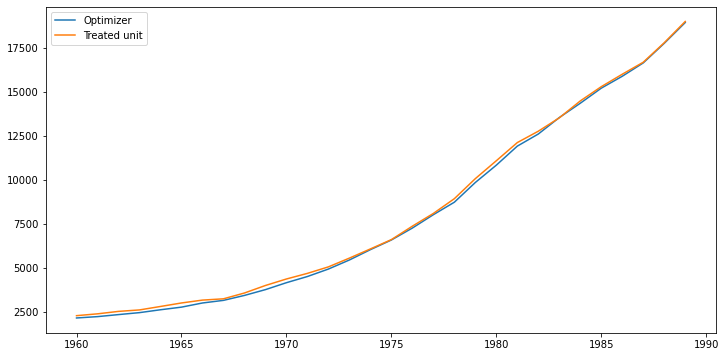

In [95]:
plt.figure(figsize=(12, 6))
plt.plot(list(range(1960, 1990)), (gen_W.T @ y_ctr)[0], label='Optimizer')
#plt.plot(np.array(range(1960, 1990)), (w_opt @ y_ctr)[0], label='Paper')
plt.plot(list(range(1960, 1990)), y_tr[0], label='Treated unit')
plt.legend()
plt.show()

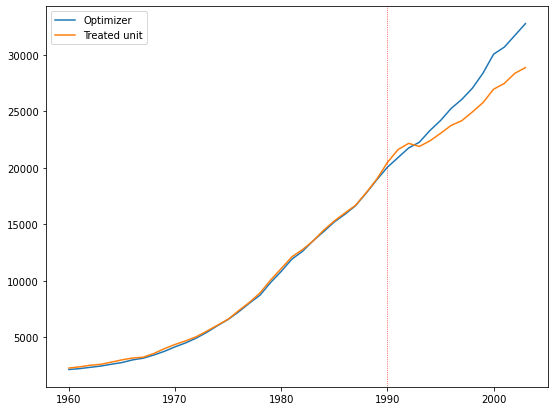

In [97]:
plt.figure(figsize=(9, 7))
plt.plot(list(data.year.unique()), (gen_W.T @ y_ctr_all)[0], label='Optimizer')
#plt.plot(list(data.year.unique()), (w_opt @ y_ctr_all)[0], label='Paper')
plt.plot(list(data.year.unique()), y_tr_all[0], label='Treated unit')
plt.axvline(1990, color='red', linewidth=.7, linestyle=':')
plt.legend()
plt.show()

In [96]:
sum((gen_W.T @ X0 - X1)[0]), sum((w_opt @ X0 - X1)[0])

(-8.232488736302061, -9.484920562009224)